<a href="https://colab.research.google.com/github/xanderkov/HSE-Machine-Learning/blob/main/hw-05/Kovel%20AI%20Homework%205%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [4]:
from pandas.api.types import is_object_dtype

for column, val_cat in df.items():
    if not is_object_dtype(df[column]):
        continue
    unique_var = df[column].unique()
    invalid_val = set(unique_var) - set(val_cat)
    if invalid_val:
        print(f'В столбце {column} не валидные значения')
    else:
        print(f'В стобце {column} всё замечательно')

В стобце experience_level всё замечательно
В стобце employment_type всё замечательно
В стобце job_title всё замечательно
В стобце salary_currency всё замечательно
В стобце employee_residence всё замечательно
В стобце company_location всё замечательно
В стобце company_size всё замечательно


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [6]:
missing_values = df.isnull().sum()

if missing_values.any():
    print("Найдены пропущенные значения в следующих столбцах:")
    print(missing_values[missing_values > 0])
else:
    print("Пропущенные значения отсутствуют.")

Пропущенные значения отсутствуют.


In [7]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Найдены {duplicates} дубликатов в данных.")
    df = df.drop_duplicates()
    print("Дубликаты были удалены.")
else:
    print("Дубликаты отсутствуют.")

Найдены 1171 дубликатов в данных.
Дубликаты были удалены.


In [8]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


Все мои действия описаны в комментариях

Не адекватных числовых значений не наблюдается

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [9]:
df = df.drop(columns=['salary', 'salary_currency'])

In [10]:
categorical_columns = ['experience_level', 'employment_type', 'job_title',
                       'employee_residence', 'company_location', 'company_size']

category_counts = {column: df[column].nunique() for column in categorical_columns}

for column, count in category_counts.items():
    print(f"Количество уникальных категорий в '{column}': {count}")

Количество уникальных категорий в 'experience_level': 4
Количество уникальных категорий в 'employment_type': 4
Количество уникальных категорий в 'job_title': 93
Количество уникальных категорий в 'employee_residence': 78
Количество уникальных категорий в 'company_location': 72
Количество уникальных категорий в 'company_size': 3


In [11]:
df = df.drop(columns=['job_title', 'employee_residence', 'company_location'])

**Ваши выводы здесь**

1. work_year: Опыт работы важен
2. experience_level: Квалификация тоже важна
3. employment_type: Тип занятости, для анализа
4. job_title: Если есть тип, то название может иметь слишком много признаков. Много признаков. Можно удалить.
5. salary: Целевой признак. Но линейно зависим с salary_in_usd
6. salary_currency: Валюта нужна. Раз есть usd, то будем без валюты жить много категорий
7. salary_in_usd: Хоть это больше на целевой сходит, так как есть ЛЗ с salary
8. employee_residence: география важна. Но очень много стран. Было бы время можно было объединить континенты
9. remote_ratio: категориальный тип хороший
10. company_location: география компании тоже нужна. Важно, но опять таки, это бы три категории по дороговизне регионов. Удаляем
11. company_size: галера не галера, важный признак

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         2584 non-null   int64 
 1   experience_level  2584 non-null   object
 2   employment_type   2584 non-null   object
 3   salary_in_usd     2584 non-null   int64 
 4   remote_ratio      2584 non-null   int64 
 5   company_size      2584 non-null   object
dtypes: int64(3), object(3)
memory usage: 141.3+ KB


## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['salary_in_usd'])
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [14]:
continuous_features = ['work_year', 'remote_ratio']
X_continuous = df[continuous_features]

X_train_continuous, X_test_continuous, y_train_continuous, y_test_continuous = train_test_split(
    X_continuous, y, test_size=0.2, random_state=42
)

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

model = LinearRegression()
model.fit(X_train_continuous, y_train_continuous)

y_pred_continuous = model.predict(X_test_continuous)

mape = mean_absolute_percentage_error(y_test_continuous, y_pred_continuous)
rmse = np.sqrt(mean_squared_error(y_test_continuous, y_pred_continuous))

print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.2f}")

MAPE: 82.91%
RMSE: 64000.53


Ну, можно и лучше. Пока что не с чем сравнить. Выводы позже.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [16]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train_continuous, y_train_continuous)

model_xgb.fit(X_train_continuous, y_train_continuous)

y_pred_continuous_xgb = model_xgb.predict(X_test_continuous)

mape_xgb = mean_absolute_percentage_error(y_test_continuous, y_pred_continuous_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_continuous, y_pred_continuous_xgb))

print(f"MAPE для XGBoost: {mape_xgb * 100:.2f}%")
print(f"RMSE для XGBoost: {rmse_xgb:.2f}")


MAPE для XGBoost: 77.08%
RMSE для XGBoost: 62433.35


Стало хуже. Но бустинги сильны в категориальных признаках. Возможно добавление их поможет улучшить ситуацию.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [17]:

y = df['salary_in_usd']

categorical_features = ['experience_level', 'employment_type', 'company_size']

X_ohe = pd.get_dummies(df.drop(columns=['salary_in_usd']), columns=categorical_features)

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y, test_size=0.2, random_state=42)

model_lr_ohe = LinearRegression()
model_lr_ohe.fit(X_train_ohe, y_train_ohe)
y_pred_lr_ohe = model_lr_ohe.predict(X_test_ohe)

model_xgb_ohe = XGBRegressor()
model_xgb_ohe.fit(X_train_ohe, y_train_ohe)
y_pred_xgb_ohe = model_xgb_ohe.predict(X_test_ohe)

print("OHE:")
print(f"Linear Regression - MAPE: {mean_absolute_percentage_error(y_test_ohe, y_pred_lr_ohe) * 100:.2f}%")
print(f"Linear Regression - RMSE: {np.sqrt(mean_squared_error(y_test_ohe, y_pred_lr_ohe)):.2f}")
print(f"XGBoost - MAPE: {mean_absolute_percentage_error(y_test_ohe, y_pred_xgb_ohe) * 100:.2f}%")
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test_ohe, y_pred_xgb_ohe)):.2f}")


OHE:
Linear Regression - MAPE: 60.40%
Linear Regression - RMSE: 56065.39
XGBoost - MAPE: 58.42%
XGBoost - RMSE: 57980.94


In [18]:
from sklearn.preprocessing import LabelEncoder

X_label_encoded = df.drop(columns=['salary_in_usd'])
label_encoder = LabelEncoder()

for column in categorical_features:
    X_label_encoded[column] = label_encoder.fit_transform(X_label_encoded[column])

X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_label_encoded, y, test_size=0.2, random_state=42)

model_lr_le = LinearRegression()
model_lr_le.fit(X_train_le, y_train_le)
y_pred_lr_le = model_lr_le.predict(X_test_le)

model_xgb_le = XGBRegressor()
model_xgb_le.fit(X_train_le, y_train_le)
y_pred_xgb_le = model_xgb_le.predict(X_test_le)

print("Label Encoding:")
print(f"Linear Regression - MAPE: {mean_absolute_percentage_error(y_test_le, y_pred_lr_le) * 100:.2f}%")
print(f"Linear Regression - RMSE: {np.sqrt(mean_squared_error(y_test_le, y_pred_lr_le)):.2f}")
print(f"XGBoost - MAPE: {mean_absolute_percentage_error(y_test_le, y_pred_xgb_le) * 100:.2f}%")
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test_le, y_pred_xgb_le)):.2f}")

Label Encoding:
Linear Regression - MAPE: 69.76%
Linear Regression - RMSE: 60424.74
XGBoost - MAPE: 60.76%
XGBoost - RMSE: 58487.46


In [19]:
%pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [20]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=categorical_features)
X_target_encoded = encoder.fit_transform(df[categorical_features], y)

X_target_encoded = pd.concat([df[['work_year', 'remote_ratio']], X_target_encoded], axis=1)

X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(X_target_encoded, y, test_size=0.2, random_state=42)

model_lr_te = LinearRegression()
model_lr_te.fit(X_train_te, y_train_te)
y_pred_lr_te = model_lr_te.predict(X_test_te)

model_xgb_te = XGBRegressor()
model_xgb_te.fit(X_train_te, y_train_te)
y_pred_xgb_te = model_xgb_te.predict(X_test_te)

print("Mean Target Encoding:")
print(f"Linear Regression - MAPE: {mean_absolute_percentage_error(y_test_te, y_pred_lr_te) * 100:.2f}%")
print(f"Linear Regression - RMSE: {np.sqrt(mean_squared_error(y_test_te, y_pred_lr_te)):.2f}")
print(f"XGBoost - MAPE: {mean_absolute_percentage_error(y_test_te, y_pred_xgb_te) * 100:.2f}%")
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test_te, y_pred_xgb_te)):.2f}")

Mean Target Encoding:
Linear Regression - MAPE: 60.33%
Linear Regression - RMSE: 55982.12
XGBoost - MAPE: 59.49%
XGBoost - RMSE: 58921.69


Лучшим из предложенных получился LabelEncoder. Но с ним качество чего-то не поднялось. Что-то тут не так

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [21]:
X_test_le.columns

Index(['work_year', 'experience_level', 'employment_type', 'remote_ratio',
       'company_size'],
      dtype='object')

In [22]:
import pandas as pd
import numpy as np

y_pred = model_xgb_le.predict(X_test_le)

errors = np.abs(y_pred - y_test_le)

error_analysis = pd.DataFrame({
    'actual': y_test_le,
    'predicted': y_pred,
    'error': errors,
    'work_year': X_test_le['work_year'],
    'experience_level': X_test_le['experience_level'],
    'employment_type': X_test_le['employment_type'],
    'remote_ratio': X_test_le['remote_ratio'],
    'company_size': X_test_le['company_size'],

})
top_errors = error_analysis.nlargest(20, 'error')

print(top_errors)

      actual      predicted          error  work_year  experience_level  \
2011  430967  110270.898438  320696.101562       2022                 2   
3517   68428  299904.562500  231476.562500       2020                 3   
3562   50180  274044.375000  223864.375000       2020                 2   
1288  385000  161761.921875  223238.078125       2023                 3   
3545  250000   40626.191406  209373.808594       2020                 0   
3455   20000  212881.546875  192881.546875       2020                 2   
2118   95000  274044.375000  179044.375000       2020                 2   
2406  315000  152016.375000  162983.625000       2022                 3   
1695   72000  223266.515625  151266.515625       2023                 3   
1847  260000  110270.898438  149729.101562       2022                 2   
2500  240000   94453.953125  145546.046875       2022                 2   
1185  288000  156849.781250  131150.218750       2023                 3   
1647  291500  161761.9218

In [23]:
min_errors = error_analysis.nsmallest(20, 'error')

print(min_errors)

      actual      predicted        error  work_year  experience_level  \
3109  160000  160077.546875    77.546875       2022                 3   
3147  148800  148499.656250   300.343750       2022                 3   
1194  156400  156849.781250   449.781250       2023                 3   
2836   93000   93522.984375   522.984375       2022                 0   
2119  115000  114469.218750   530.781250       2021                 3   
43    110680  111369.398438   689.398438       2023                 0   
3035   61566   62276.578125   710.578125       2022                 2   
233   162500  161761.921875   738.078125       2023                 3   
896   116990  115809.937500  1180.062500       2023                 2   
2618  150000  148499.656250  1500.343750       2022                 3   
3362  150260  152016.375000  1756.375000       2022                 3   
2998  154000  152016.375000  1983.625000       2022                 3   
1704   72914   70888.742188  2025.257812       2023

**Ваш ответ здесь**.

Смотрю на раличие цифр самых малых и больших. В целом вывод тут сложно сделать.
Возможно тех зарплат, которых больше всего, их легче предсказывать.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [24]:
df['experience_remote_ratio'] = df['work_year'] * df['remote_ratio'] / 100
df['job_salary_scale'] = df['work_year'] / df['company_size'].map({'small': 1, 'medium': 2, 'large': 3})

new_features = ['work_year', 'remote_ratio', 'experience_remote_ratio', 'job_salary_scale'] + categorical_features

X_new = df[new_features]

X_new = pd.get_dummies(X_new, columns=categorical_features)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)

model_xgb_new = XGBRegressor()
model_xgb_new.fit(X_train_new, y_train_new)
y_pred_xgb_new = model_xgb_new.predict(X_test_new)

mape_new = mean_absolute_percentage_error(y_test_new, y_pred_xgb_new)
rmse_new = np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_new))

print("Новые признаки:")
print(f"XGBoost - MAPE: {mape_new * 100:.2f}%")
print(f"XGBoost - RMSE: {rmse_new:.2f}")

Новые признаки:
XGBoost - MAPE: 58.08%
XGBoost - RMSE: 58028.32


**Ваш ответ здесь**.

Были выдвинуты новые признаки, полученные на основе предыдущих, но модель чет не улучшилась.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2067 entries, 25 to 1230
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         2067 non-null   int64 
 1   experience_level  2067 non-null   object
 2   employment_type   2067 non-null   object
 3   remote_ratio      2067 non-null   int64 
 4   company_size      2067 non-null   object
dtypes: int64(2), object(3)
memory usage: 96.9+ KB


In [26]:
categorical_features

['experience_level', 'employment_type', 'company_size']

In [27]:
%pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2067 entries, 25 to 1230
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         2067 non-null   int64 
 1   experience_level  2067 non-null   object
 2   employment_type   2067 non-null   object
 3   remote_ratio      2067 non-null   int64 
 4   company_size      2067 non-null   object
dtypes: int64(2), object(3)
memory usage: 96.9+ KB


In [32]:
from catboost import CatBoostRegressor, Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model.fit(train_pool)
y_pred = model.predict(test_pool)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.2f}")

0:	learn: 65894.8099664	total: 54.4ms	remaining: 54.4s
100:	learn: 55940.7365323	total: 484ms	remaining: 4.3s
200:	learn: 54972.6793863	total: 914ms	remaining: 3.63s
300:	learn: 53993.3990480	total: 1.39s	remaining: 3.24s
400:	learn: 53300.2706989	total: 1.85s	remaining: 2.76s
500:	learn: 52675.4433439	total: 2.32s	remaining: 2.31s
600:	learn: 52157.5659367	total: 2.79s	remaining: 1.85s
700:	learn: 51584.6947059	total: 3.19s	remaining: 1.36s
800:	learn: 51184.8982491	total: 3.35s	remaining: 834ms
900:	learn: 50749.3200468	total: 3.55s	remaining: 390ms
999:	learn: 50405.8484075	total: 3.72s	remaining: 0us
MAPE: 58.90%
RMSE: 57656.11


In [33]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

catboost_model = CatBoostRegressor(cat_features=categorical_features)

param_dist = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [2, 3, 5]
}

search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

print(f"Лучшие гиперпараметры: {search.best_params_}")

best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)

mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"MAPE (оптимальные гиперпараметры): {mape_best * 100:.2f}%")
print(f"RMSE (оптимальные гиперпараметры): {rmse_best:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 67215.0517171	total: 6.8ms	remaining: 3.4s
1:	learn: 67067.1559838	total: 11.8ms	remaining: 2.94s
2:	learn: 66935.8912251	total: 15.4ms	remaining: 2.55s
3:	learn: 66792.8462396	total: 19.8ms	remaining: 2.46s
4:	learn: 66676.9966953	total: 23.3ms	remaining: 2.31s
5:	learn: 66532.6652295	total: 29.1ms	remaining: 2.4s
6:	learn: 66400.9923674	total: 32.8ms	remaining: 2.31s
7:	learn: 66269.4234756	total: 38.6ms	remaining: 2.37s
8:	learn: 66182.0103274	total: 40.3ms	remaining: 2.19s
9:	learn: 66046.2754743	total: 43.5ms	remaining: 2.13s
10:	learn: 65923.1712420	total: 46.7ms	remaining: 2.08s
11:	learn: 65809.3858837	total: 55.4ms	remaining: 2.25s
12:	learn: 65689.8711883	total: 59.5ms	remaining: 2.23s
13:	learn: 65571.4163693	total: 62.6ms	remaining: 2.17s
14:	learn: 65441.3875184	total: 66.8ms	remaining: 2.16s
15:	learn: 65315.9544403	total: 70.8ms	remaining: 2.14s
16:	learn: 65217.0561989	total: 72.8ms	remaining: 2.07s


In [35]:
y_pred_best = best_model.predict(X_test)

Скорость обучения была около 3 секунд.

Скорость предсказания быстрая.

Качество не отличимо от xgboost

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [36]:
model_xgb_le = XGBRegressor()
model_xgb_le.fit(X_train_le, y_train_le)
y_pred_xgb_le = model_xgb_le.predict(X_test_le)

print(f"XGBoost - MAPE: {mean_absolute_percentage_error(y_test_le, y_pred_xgb_le) * 100:.2f}%")
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test_le, y_pred_xgb_le)):.2f}")

XGBoost - MAPE: 60.76%
XGBoost - RMSE: 58487.46


In [50]:
%pip uninstall category-encoders -q
%pip uninstall scikit-learn -q
%pip install scikit-learn==1.5.2 -q

Proceed (Y/n)? y


In [53]:
param_dist = {
    'iterations': [500, 1000, 1500],
    'max_depth': [4, 6, 8],
    'eta': [0.01, 0.05, 0.1],
}

search = RandomizedSearchCV(model_xgb_le, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
search.fit(X_train_le, y_train_le)

print(f"Лучшие гиперпараметры: {search.best_params_}")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [38]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test_le)

mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"MAPE (оптимальные гиперпараметры): {mape_best * 100:.2f}%")
print(f"RMSE (оптимальные гиперпараметры): {rmse_best:.2f}")

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

В целом код есть. Что происходит со связими двух либ не знаю
Оставлю так могу сказать, что

XGboost в целом быстрее Catboost, что логично

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [55]:
import lightgbm
from lightgbm import LGBMClassifier

lightgbm = LGBMClassifier(n_estimators=300)

In [ ]:
lightgbm.fit(X_train_le, y_train_le)

In [57]:
y_pred_lightgbm_le = lightgbm.predict(X_test_le)

print(f"LIghtGBM - MAPE: {mean_absolute_percentage_error(y_test_le, y_pred_lightgbm_le) * 100:.2f}%")
print(f"LIghtGBM - RMSE: {np.sqrt(mean_squared_error(y_test_le, y_pred_lightgbm_le)):.2f}")

LIghtGBM - MAPE: 90.72%
LIghtGBM - RMSE: 80675.30


In [ ]:
param_dist = {
    'iterations': [100, 200],
    'max_depth': [4, 6],
    'eta': [0.01, 0.05, 0.1],
}

search = RandomizedSearchCV(lightgbm, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
search.fit(X_train_le, y_train_le)

print(f"Лучшие гиперпараметры: {search.best_params_}")

In [ ]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test_le)

mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"MAPE (оптимальные гиперпараметры): {mape_best * 100:.2f}%")
print(f"RMSE (оптимальные гиперпараметры): {rmse_best:.2f}")

Вы меня спросите, а почему самая быстрая модель обучилась лучше всех, и при этом училась лучше всех. А я не знаю.

Смотрю и сам удивляюсь.

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

1. LightGBM
2. CatBoost
3. Только LightGBM в итоге обошел линейную регрессию. Возможно дело в каких-то еще параметрах, который я не учел. Но исходя из теории, то бустинги должны почти всегда отрабатывать лучше

В целом, скорее всего, плохие результаты были, жестким отбрасыванием категориальных признаков.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [6]:
import numpy as np

X_train = np.loadtxt('samsung_train.txt')
y_train = np.loadtxt('samsung_train_labels.txt')
X_test = np.loadtxt('samsung_test.txt')
y_test = np.loadtxt('samsung_test_labels.txt')

X = np.concatenate((X_train, X_test), axis=0)

y = np.concatenate((y_train, y_test), axis=0)

print("Размерность X:", X.shape)
print("Размерность y:", y.shape)

Размерность X: (10299, 561)
Размерность y: (10299,)


In [7]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1., 2., 3., 4., 5., 6.])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [8]:
from sklearn.preprocessing import StandardScaler

X = np.concatenate((X_train, X_test), axis=0)

y = np.concatenate((y_train, y_test), axis=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Размерность X:", X.shape)
print("Размерность y:", y.shape)
print("Размерность X_scaled:", X_scaled.shape)

Размерность X: (10299, 561)
Размерность y: (10299,)
Размерность X_scaled: (10299, 561)


### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(explained_variance_ratio >= 0.90) + 1

pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

print("Количество компонент, необходимых для объяснения 90% дисперсии:", n_components)
print("Размерность оригинальных данных:", X.shape)
print("Размерность данных после понижения размерности (PCA):", X_reduced.shape)

Количество компонент, необходимых для объяснения 90% дисперсии: 65
Размерность оригинальных данных: (10299, 561)
Размерность данных после понижения размерности (PCA): (10299, 65)


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

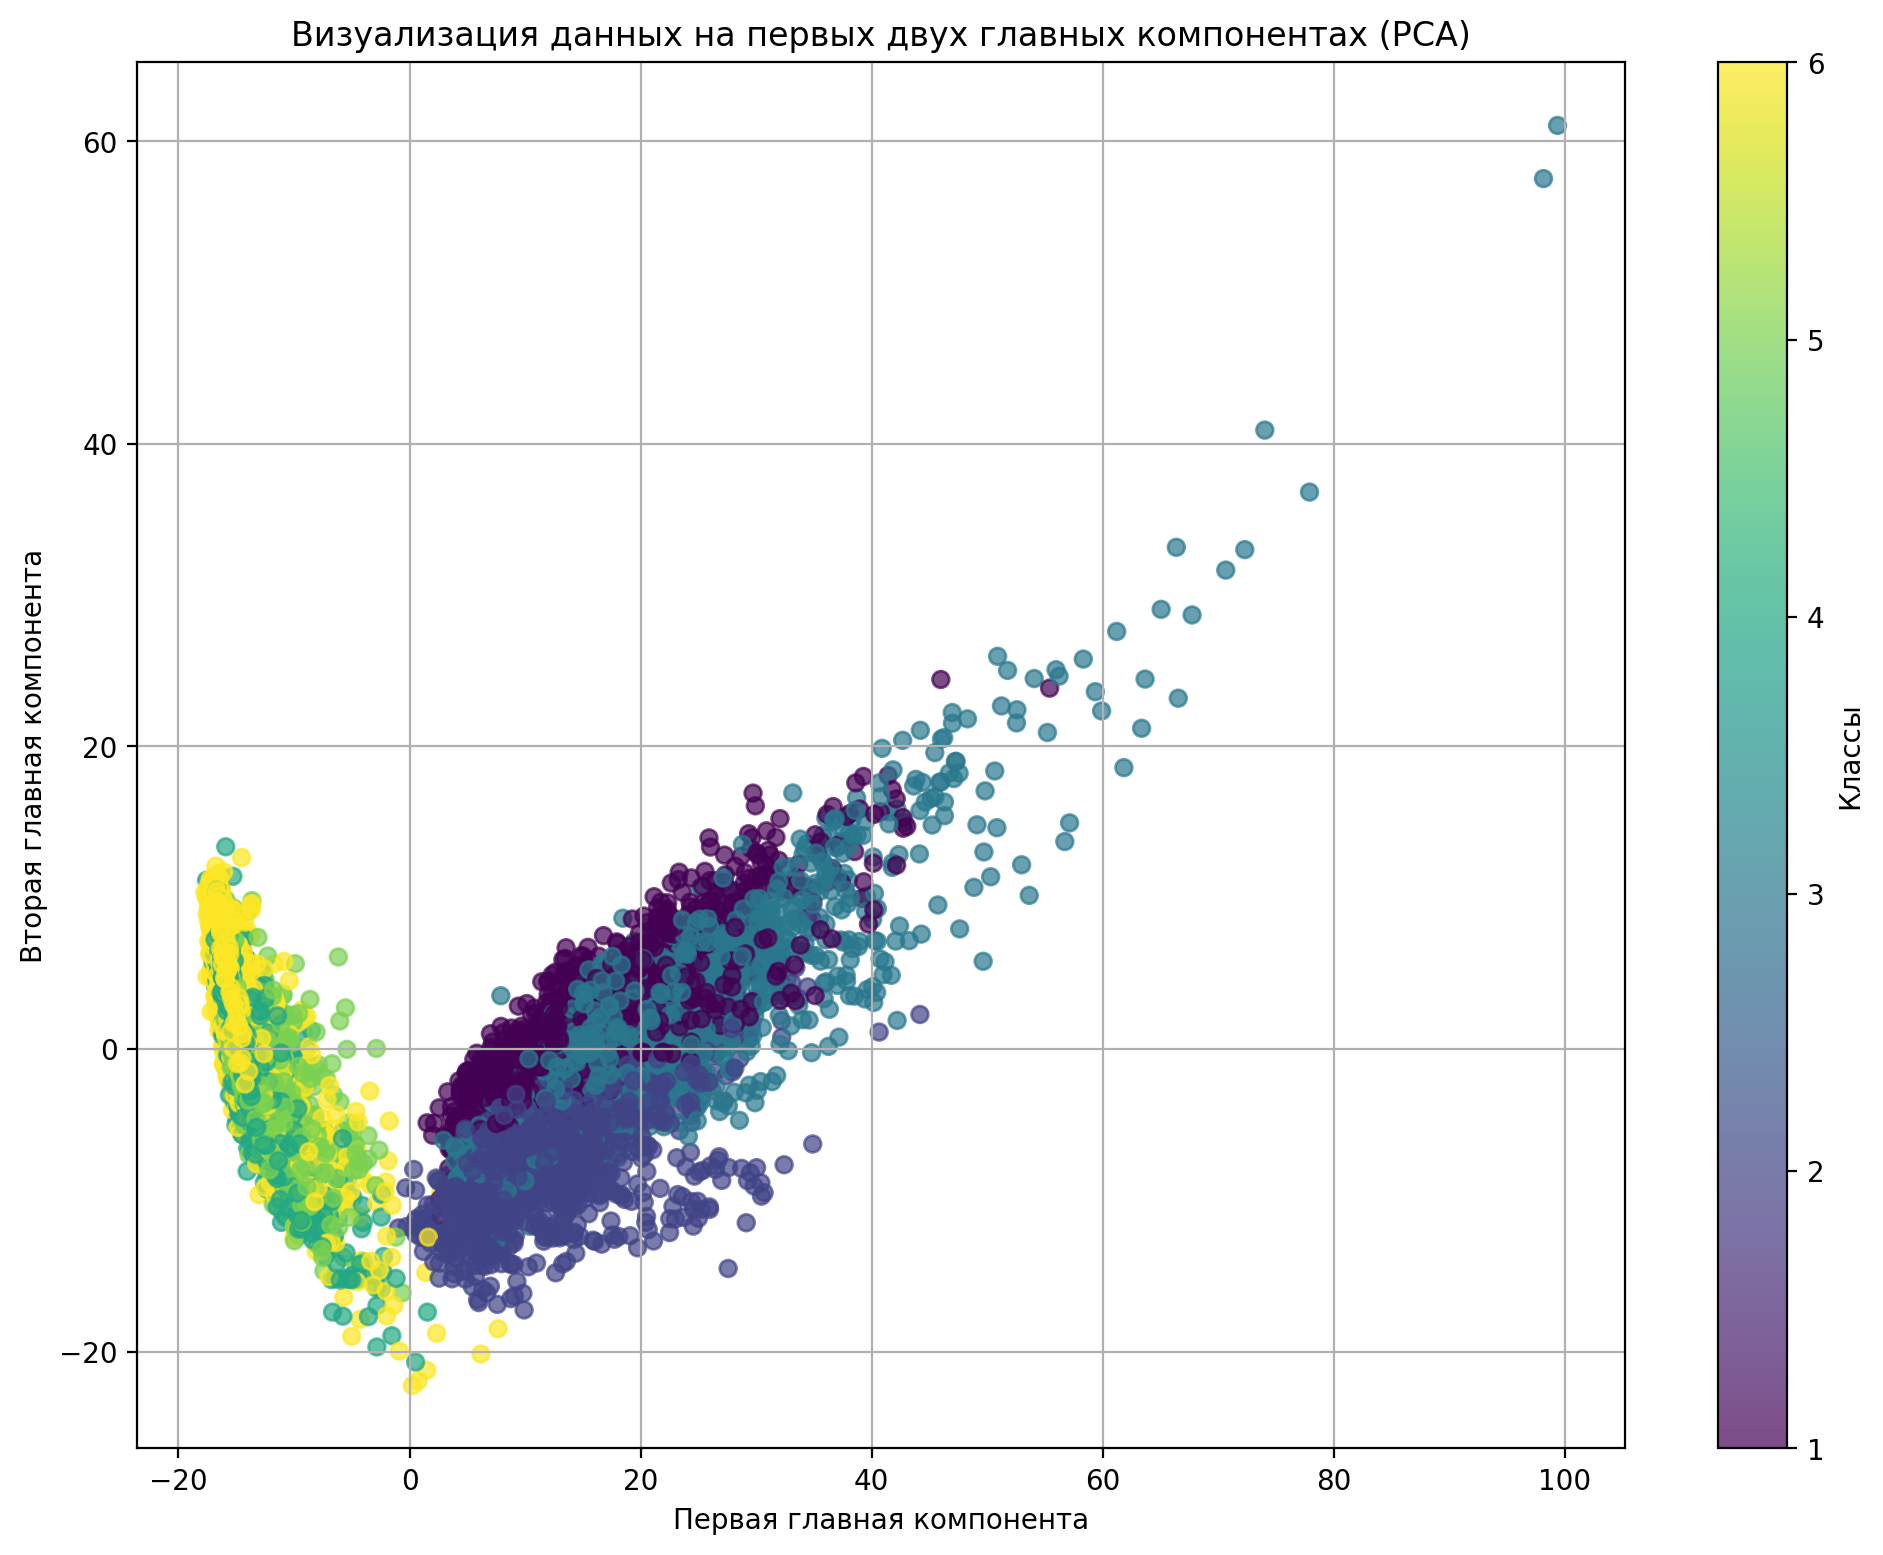

In [11]:
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Классы')
plt.title('Визуализация данных на первых двух главных компонентах (PCA)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid()
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time

RANDOM_STATE = 42

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)


In [27]:
start_time = time.time()
kmeans.fit(X_reduced)
training_time = time.time() - start_time

print("Время обучения KMeans: {:.4f} секунд".format(training_time))

Время обучения KMeans: 9.3062 секунд


In [28]:
start_time = time.time()
labels = kmeans.predict(X_reduced)
inference_time = time.time() - start_time
print("Время инференса KMeans: {:.4f} секунд".format(inference_time))

Время инференса KMeans: 0.0041 секунд


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

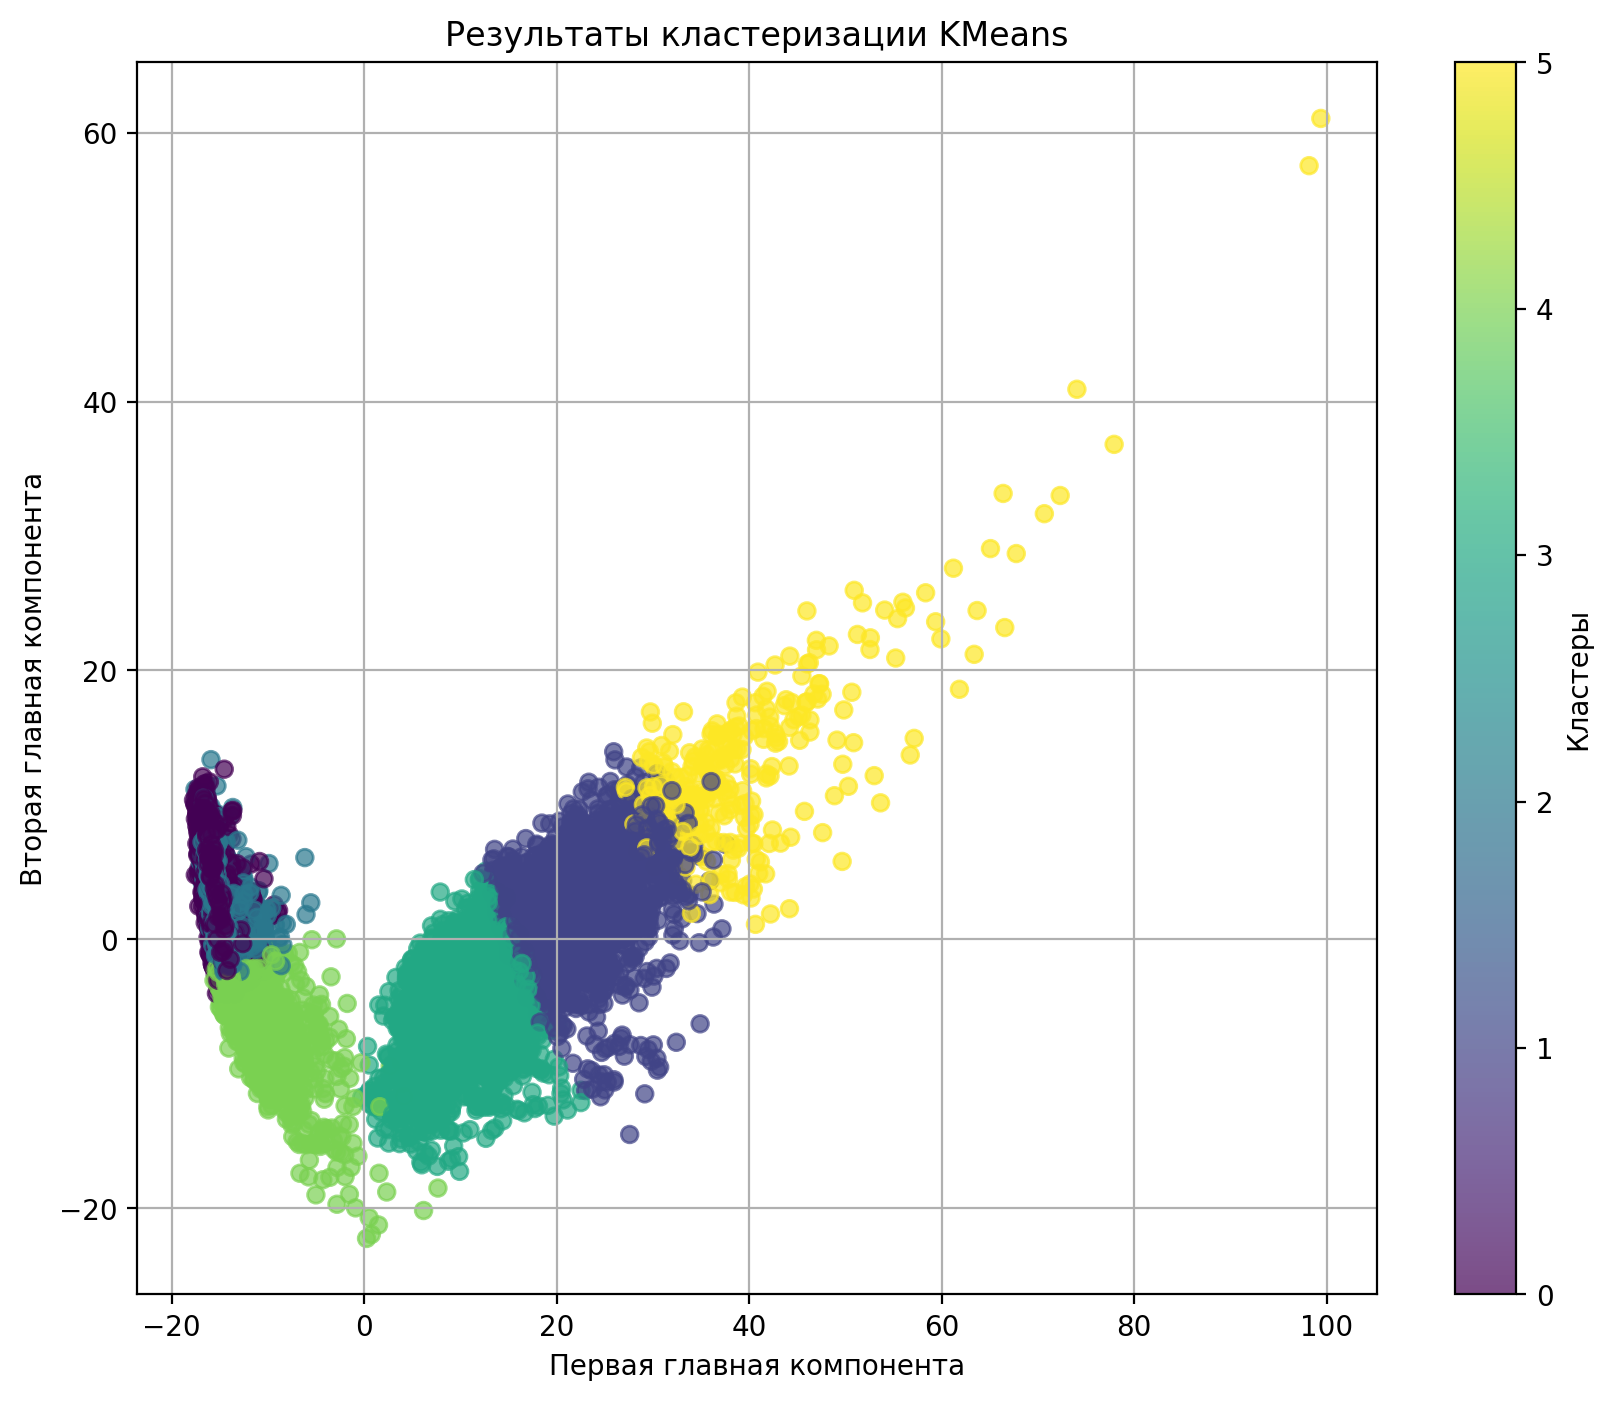

In [29]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Кластеры')
plt.title('Результаты кластеризации KMeans')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid()
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

silhouette_avg = silhouette_score(X_reduced, labels)
k_means_davies = davies_bouldin_score(X_reduced, labels)

print("Средний силуэтный коэффициент: {:.4f}".format(silhouette_avg))
print("Индекс Дэвиса-Булдина: {:.4f}".format(k_means_davies))

Средний силуэтный коэффициент: 0.1415
Индекс Дэвиса-Булдина: 2.0519


**Ваш вывод здесь**

Силуэтный коэффициент указывает на приемлемую кластеризацию, но есть возможность для улучшения.

Индекс Дэвиса-Булдина слишком высок, что может указывать на проблемы с кластеризацией.


Выбрана одна внутренняя метрика из степика.

Вторая выбрана была такой, так как она единственная заработала с предложенными labels

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [31]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 6
agglo_clustering = AgglomerativeClustering(n_clusters=n_clusters)

start_time = time.time()
agglo_labels = agglo_clustering.fit_predict(X_reduced)
training_time = time.time() - start_time


print("Agglomerative Clustering:")
print("Время обучения и инференса: {:.4f} секунд".format(training_time))

Agglomerative Clustering:
Время обучения и инференса: 11.1043 секунд


In [32]:
silhouette_avg_agglo = silhouette_score(X_reduced, agglo_labels)
davies_bouldin_avg_agglo = davies_bouldin_score(X_reduced, agglo_labels)

print("Средний силуэтный коэффициент (Silhouette Score): {:.4f}".format(silhouette_avg_agglo))
print("Индекс Дэвиса-Булдина (Davies-Bouldin Index): {:.4f}".format(davies_bouldin_avg_agglo))

Средний силуэтный коэффициент (Silhouette Score): 0.1366
Индекс Дэвиса-Булдина (Davies-Bouldin Index): 2.0443


In [33]:
print("Сравнение с KMeans:")
print("Силуэтный коэффициент KMeans: {:.4f}, Силуэтный коэффициент Agglomerative: {:.4f}".format(silhouette_avg, silhouette_avg_agglo))
print("Индекс Дэвиса-Булдина KMeans: {:.4f}, Индекс Дэвиса-Булдина Agglomerative: {:.4f}".format(k_means_davies, davies_bouldin_avg_agglo))

Сравнение с KMeans:
Силуэтный коэффициент KMeans: 0.1415, Силуэтный коэффициент Agglomerative: 0.1366
Индекс Дэвиса-Булдина KMeans: 2.0519, Индекс Дэвиса-Булдина Agglomerative: 2.0443


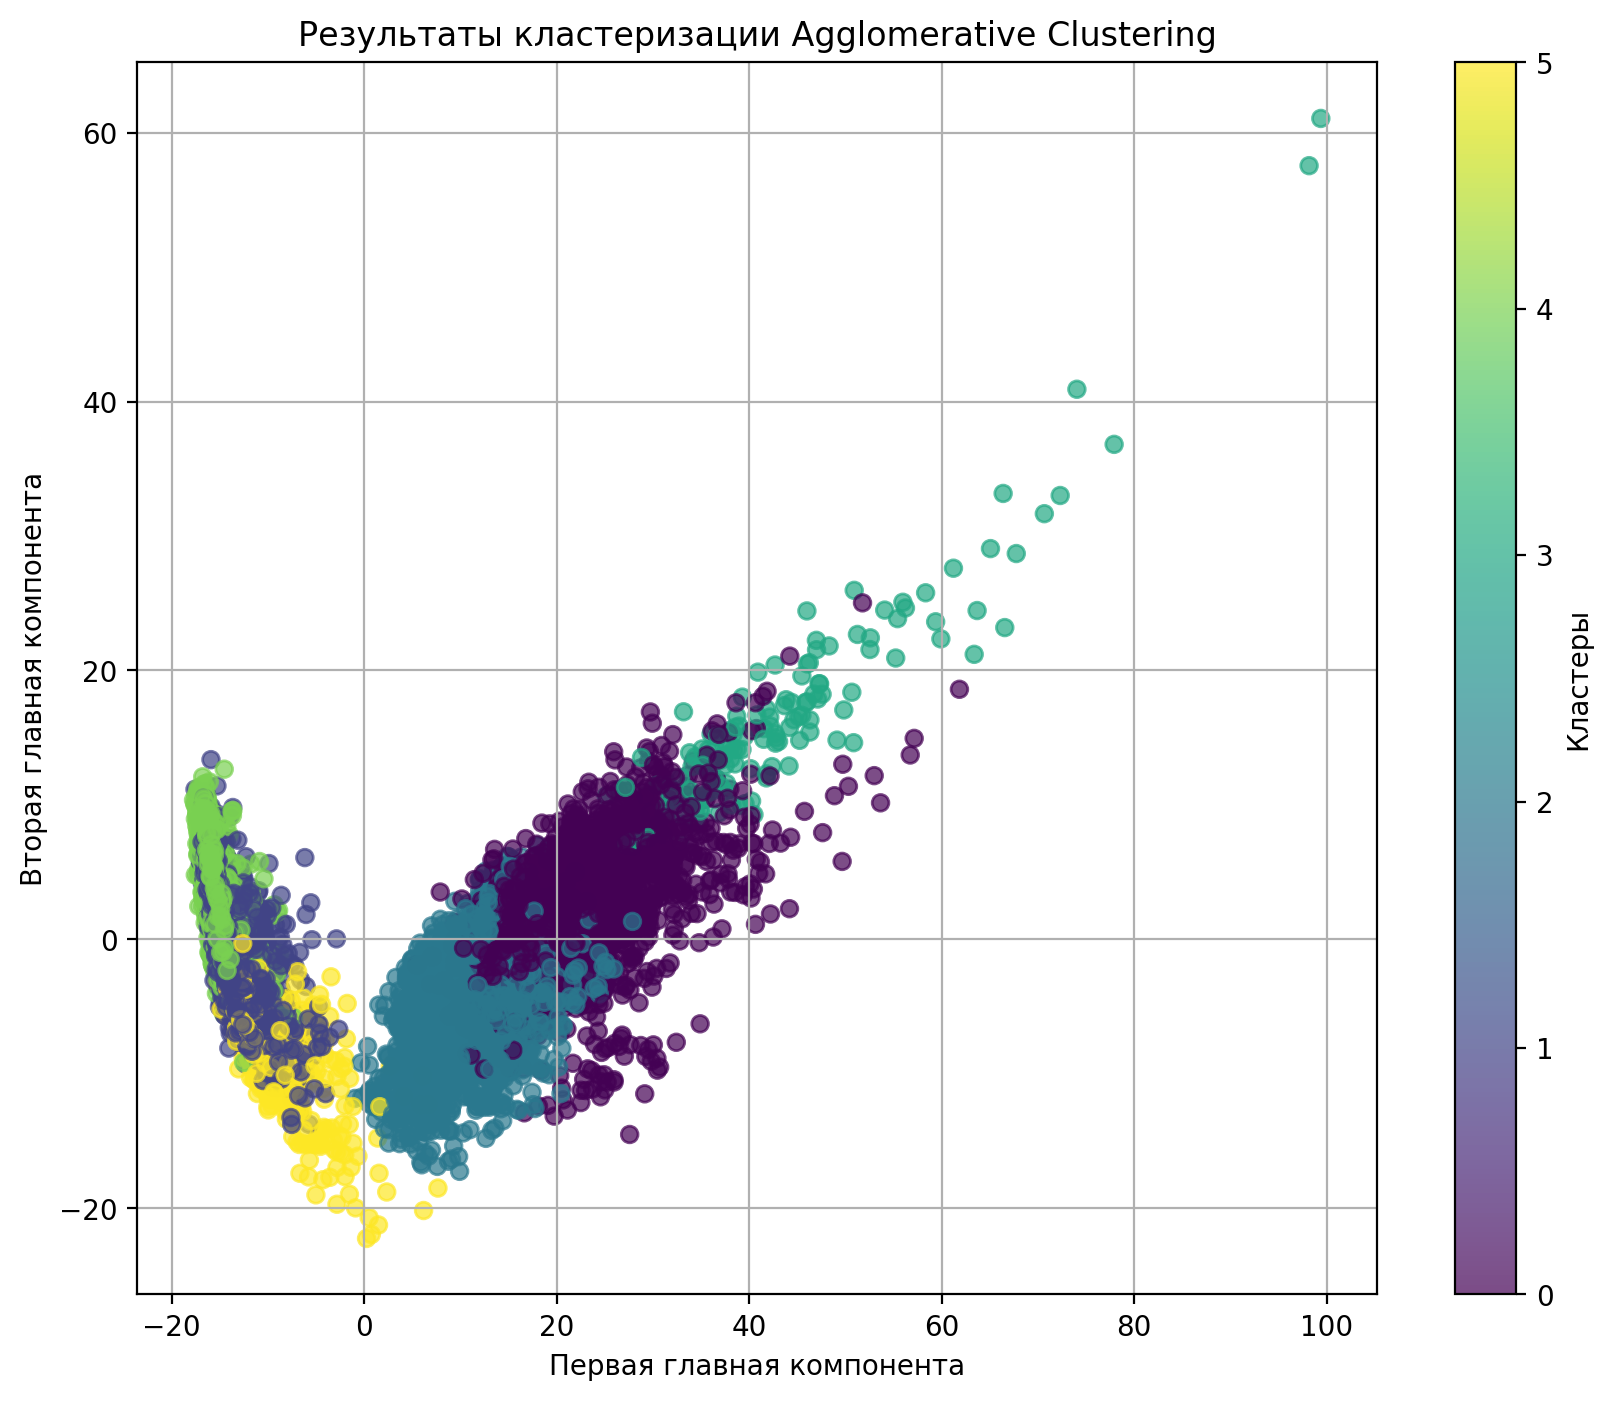

In [34]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=agglo_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Кластеры')
plt.title('Результаты кластеризации Agglomerative Clustering')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid()
plt.show()

**Ваш вывод здесь**

Агломеративный кластер, не сделал прям уж таких прямых линий, и на глаз кажется приятнее Kmeans. Но логично, что по метрикам они схожи, так как по итогу рисунко такой и получется.

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?


**Ваш вывод здесь**

Возможно у меня получилась не совсем верная визуализация

Будто бы всего тут два класса с активными людьми и нет.

Видно по этой галке, и уже внутри мы их просто по удалению распределяем.

Кластеризация как по мне так себе, ничего интересного не дала

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

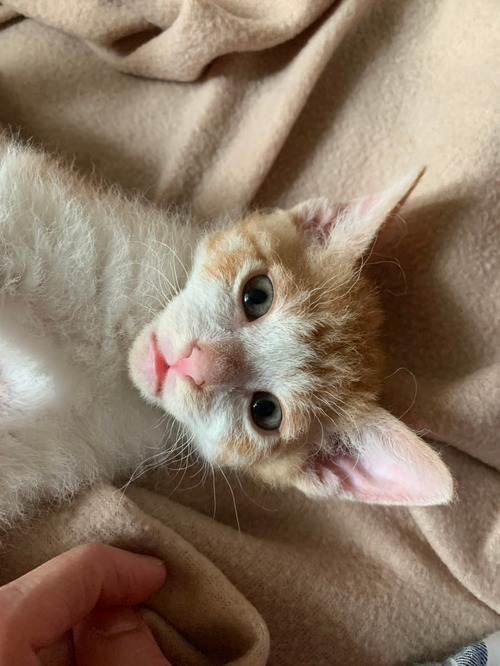

Пусть будет Георгий Чешко